In [1]:
import warnings
import numpy as np
print("connected to server")
import torch
import matplotlib.pyplot as plt

from visualizer import get_local
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

connected to server


Loading Model and Dataset

In [ ]:
device = 'cuda:1'

get_local.activate() # 在引入模型之前，激活装饰器
model_path = "../model_cache"
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, torch_dtype=torch.bfloat16).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

In [10]:
gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
# minerva_math_dataset = load_dataset('math-ai/minervamath')
# gpqa_dataset = load_dataset('math-ai/gpqa')
# mmlu_dataset_us_history = load_dataset('cais/mmlu', 'high_school_us_history')
# arc_dataset_challenge = load_dataset('allenai/ai2_arc', 'ARC-Challenge')

In [11]:
gsm8k_dataset['test']

Dataset({
    features: ['question', 'answer'],
    num_rows: 1319
})

In [ ]:
# minerva_math_dataset['test']

In [ ]:
# gpqa_dataset['test']

step-position weights

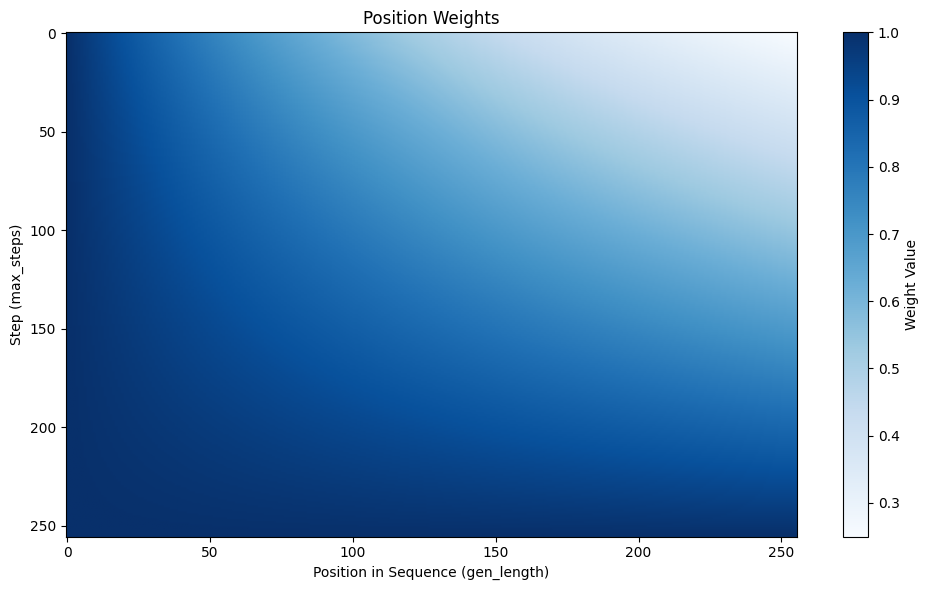

In [9]:
from sampler.utils import _precompute_positional_weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

position_weights = _precompute_positional_weights(
    max_steps=256,
    gen_length=256,
    max_weight=1.0,
    initial_min_weight=0.25,
    device=DEVICE
)

data_to_plot = position_weights.cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 6))
# cmap='Blues' 是一个很好的单色选项，也可以换成 'Greys', 'Greens', 'Reds' 等
im = ax.imshow(data_to_plot, cmap='Blues', aspect='auto')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Weight Value')

ax.set_title('Position Weights')
ax.set_xlabel('Position in Sequence (gen_length)')
ax.set_ylabel('Step (max_steps)')

plt.tight_layout()
# plt.savefig('./imgs/position_weights/weights_heatmap.png', dpi=150)
# print("heatmap saved to 'weights_heatmap.png'")
plt.show()
